# DSC511 Group Project: Hotel Review Sentiment Analysis and Rating Prediction

## Authors

- Maria Tsilidou
- Anastasios Nikodimou
- Ioannis Demetriou

In [ ]:
# Importing libraries

import folium
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import os
import seaborn as sns
import pandas as pd

from nltk.stem import WordNetLemmatizer

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import RegexTokenizer, StringIndexer, StopWordsRemover
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql.functions import(
    array,
    array_contains,
    arrays_zip,
    expr,
    col,
    concat_ws,
    explode,
    length,
    lit,
    lower,
    regexp_extract,
    regexp_replace,
    size,
    split,
    sum as Fsum,
    to_date,
    trim,
    udf,
    when
)
from pyspark.sql.types import ArrayType, BooleanType, FloatType, IntegerType, StringType

sns.set_palette("viridis")
# Get or create a SparkSession object
spark = SparkSession.builder.appName("DSC511-GroupProject").master("local[*]").config("spark.driver.memory", "10g").getOrCreate()

## Exploratory Data Analysis

In this section we will load, understand the dimension and schema, and explore our
dataset.

The dataset is obtained from [here](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe).


The csv file contains 17 fields. The description of each field is as below:

- `Hotel_Address`: Address of hotel.
- `Review_Date`: Date when reviewer posted the corresponding review.
- `Average_Score`: Average Score of the hotel, calculated based on the latest comment in the last year.
- `Hotel_Name`: Name of Hotel
- `Reviewer_Nationality`: Nationality of Reviewer
- `Negative_Review`: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
- `Review_Total_Negative_Word_Counts`: Total number of words in the negative review.
- `Positive_Review`: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
- `Review_Total_Positive_Word_Counts`: Total number of words in the positive review.
- `Reviewer_Score`: Score the reviewer has given to the hotel, based on his/her experience
- `Total_Number_of_Reviews_Reviewer_Has_Given`: Number of Reviews the reviewers has given in the past.
- `Total_Number_of_Reviews`: Total number of valid reviews the hotel has.
- `Tags`: Tags reviewer gave the hotel.
- `days_since_review`: Duration between the review date and scrape date.
- `Additional_Number_of_Scoring`: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.
- `lat`: Latitude of the hotel
- `lng`: longtitude of the hotel

Here we took advantage of spark's ability to understand files compressed with gzip
and we added the dataset in a `.csv.gz` form.

In [ ]:
# Loading dataset

# Note: inferSchema=True is "expensive". Consider removing it for performance if needed
# Consider fitting the once deduced `original_schema` while re-running this

original = spark.read.csv('./data/Hotel_Reviews.csv.gz', header=True, inferSchema=True)
original_schema = original.schema

In [1]:
# Getting an idea about the dataset's shape

original_count = original.count()
print(f'Number of observations: {original_count}')
print(f'Number of features: {len(original_schema)}')

Number of observations: 515738
Number of features: 17


### Understanding the dataset

The dataset appears to be the "exploded" join of a hotel, reviewer and review table. In particular,

Hotel:

- `Hotel_Name`: Name of Hotel
- `Hotel_Address`: Address of hotel.
- `lat`: Latitude of the hotel
- `lng`: longtitude of the hotel
- `Average_Score`: Average Score of the hotel, calculated based on the latest comment in the last year.
- `Total_Number_of_Reviews`: Total number of valid reviews the hotel has.

Reviewer:

- `Reviewer_Nationality`: Nationality of Reviewer
- `Total_Number_of_Reviews_Reviewer_Has_Given`: Number of Reviews the reviewers has given in the past.

Review:

- `Review_Date`: Date when reviewer posted the corresponding review.
- `Negative_Review`: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
- `Review_Total_Negative_Word_Counts`: Total number of words in the negative review.
- `Positive_Review`: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
- `Review_Total_Positive_Word_Counts`: Total number of words in the positive review.
- `Reviewer_Score`: Score the reviewer has given to the hotel, based on his/her experience
- `Tags`: Tags reviewer gave the hotel.
- `days_since_review`: Duration between the review date and scrape date.
- `Additional_Number_of_Scoring`: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.

In [2]:
# We visualize the first entries in order to decide our next steps

original.printSchema()

original.select(
    'Hotel_Name', 'Reviewer_Nationality',
    'Review_Date', 'Negative_Review', 'Positive_Review', 'Tags', 'days_since_review'
    ).show(5, truncate=15)

root
 |-- Hotel_Address: string (nullable = true)
 |-- Additional_Number_of_Scoring: integer (nullable = true)
 |-- Review_Date: string (nullable = true)
 |-- Average_Score: double (nullable = true)
 |-- Hotel_Name: string (nullable = true)
 |-- Reviewer_Nationality: string (nullable = true)
 |-- Negative_Review: string (nullable = true)
 |-- Review_Total_Negative_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews: integer (nullable = true)
 |-- Positive_Review: string (nullable = true)
 |-- Review_Total_Positive_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews_Reviewer_Has_Given: integer (nullable = true)
 |-- Reviewer_Score: double (nullable = true)
 |-- Tags: string (nullable = true)
 |-- days_since_review: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lng: string (nullable = true)

+-----------+--------------------+-----------+---------------+---------------+---------------+-----------------+
| Hotel_Name|Reviewer_Nationality|R

### Cleaning the dataset

We want to check the quality of our dataset. Since we are dealing with reviews,
we want to check if:

- There are missing values
- There are duplicate entries
- There are any outliers or noise
- There are obvious erroneous entries
- There are missing features

In [3]:
cleaned = original

# Checking for missing values

# Counting nulls in each column
missing_counts = cleaned.select([Fsum(col(c).isNull().cast("int")).alias(c) for c in cleaned.columns])

missing_counts.show()

# There are empty values in the dataset but the are not shown here

+-------------+----------------------------+-----------+-------------+----------+--------------------+---------------+---------------------------------+-----------------------+---------------+---------------------------------+------------------------------------------+--------------+----+-----------------+---+---+
|Hotel_Address|Additional_Number_of_Scoring|Review_Date|Average_Score|Hotel_Name|Reviewer_Nationality|Negative_Review|Review_Total_Negative_Word_Counts|Total_Number_of_Reviews|Positive_Review|Review_Total_Positive_Word_Counts|Total_Number_of_Reviews_Reviewer_Has_Given|Reviewer_Score|Tags|days_since_review|lat|lng|
+-------------+----------------------------+-----------+-------------+----------+--------------------+---------------+---------------------------------+-----------------------+---------------+---------------------------------+------------------------------------------+--------------+----+-----------------+---+---+
|            0|                           0|        

After further investigating the dataset we noticed that there are empty values that are not treated as null. This may be happening becuase there are empty strings and not null values or they might contain invisible characters (e.g. space). We will replace the empty string with null so that Sparks recognises it and treats it as a missing value.

In [ ]:
# Replacing empty strings with Spark's null
for c in cleaned.columns:
    cleaned = cleaned.withColumn(c, when(trim(col(c)) == '', None).otherwise(col(c)))

In [4]:
# Rerunning the previous code to check whether the empty strings got indeed converted to null

missing_counts_new = cleaned.select([Fsum(col(c).isNull().cast("int")).alias(c) for c in cleaned.columns])
missing_counts_new.show()

+-------------+----------------------------+-----------+-------------+----------+--------------------+---------------+---------------------------------+-----------------------+---------------+---------------------------------+------------------------------------------+--------------+----+-----------------+---+---+
|Hotel_Address|Additional_Number_of_Scoring|Review_Date|Average_Score|Hotel_Name|Reviewer_Nationality|Negative_Review|Review_Total_Negative_Word_Counts|Total_Number_of_Reviews|Positive_Review|Review_Total_Positive_Word_Counts|Total_Number_of_Reviews_Reviewer_Has_Given|Reviewer_Score|Tags|days_since_review|lat|lng|
+-------------+----------------------------+-----------+-------------+----------+--------------------+---------------+---------------------------------+-----------------------+---------------+---------------------------------+------------------------------------------+--------------+----+-----------------+---+---+
|            0|                           0|        

Now it is obvious that the columns `Reviewer_Nationality`, `Negative_Review` and `Positive_Review` contain null values that spark can identify.

Since we trated the empty strings we can deal with null values that have other forms.
In many datasets missing values can be represented as 'NA' (a string) instead of null.
Spark won’t treat 'NA' as a missing value unless we explicitly handle it.
So if we're only checking for null, we might miss those 'fake nulls'.
This is why we need to check each column for the presence of 'fake nulls'.

In [5]:
# Define your list of fake/null-like strings
fake_nulls = ['NA', 'N/A', 'na', 'n/a', 'null', 'None', ' N A', ' n a', ' N a']

# Creating an empty list to collect the column names and NA counts
fake_null_counts = []

# Loop through columns and count fake nulls in each
for column in cleaned.columns:
    count = cleaned.select(
        Fsum(when(col(column).isin(fake_nulls), 1).otherwise(0)).alias("fake_null_count")
    ).collect()[0]["fake_null_count"]

    if count > 0:
        fake_null_counts.append((column, count))

# Displaying
spark.createDataFrame(fake_null_counts, ["column", "fake_null_count"]).show(truncate=False)

+---------------+---------------+
|column         |fake_null_count|
+---------------+---------------+
|Negative_Review|1773           |
|Positive_Review|53             |
|lat            |3268           |
|lng            |3268           |
+---------------+---------------+



In total we have 9,917 missing values (1.9% of the whole dataset).
There are more cases of missing values that will be analysed later.
We will also later on convert all these fake null values into null values that Spark
can actually process (just like we did with the empty strings).

In [6]:
# Checking for duplicates
cleaned = cleaned.drop_duplicates()

print(f'From our dataset, {cleaned.count()} / {original.count()} are distinct')

From our dataset, 515212 / 515738 are distinct


### Type casting the dataset

We now inspect the schema and encoding of our features. We want to cast the data
into a format that will be easier to process.

From the schema and the first few observations, we see that we can benefit
from casting to more python friendly instances, or categorical features that
can be encoded as such.

Some datasets use different string literals to mean missing data. These include
'NA', 'No Review', 'N/A', NONE', 'NULL', 'MISSING', '', 0, etc.

Let's harmonize by replacing such data with `None` and cast the coordinates
decimal degrees to float.

In [7]:
# We notice that lon/lat represented here as decimal degrees should be numeric,
# but they are typed as strings. This could mean that there are some "hard-coded" NAs

print('Hotels with missing coordinates')
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(~col('lng').rlike(r'[0-9]') | ~col('lat').rlike(r'[0-9]'))\
    .distinct()\
    .show(truncate=False)

# It seems that 'NA' is `None`. Let's update it
cleaned = cleaned\
    .withColumn(
        'lng',
        when(col('lng') == 'NA', lit(None)).otherwise(col('lng'))
    ).withColumn(
        'lat',
        when(col('lat') == 'NA', lit(None)).otherwise(col('lat'))
    ).withColumn(
        'lng',
        col('lng').cast(FloatType())
    ).withColumn(
        'lat',
        col('lat').cast(FloatType())
    )

# Verify
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(~col('lng').rlike(r'[0-9]') | ~col('lat').rlike(r'[0-9]') | col('lng').isNull() | col('lat').isNull())\
    .distinct()\
    .show(truncate=False)

# Entries with missing lon/lat
print('Number of reviews with missing coordinates:')
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(col('lng').isNull() | col('lat').isNull())\
    .count()

Hotels with missing coordinates
+-----------------------------------------------------------+---+---+
|Hotel_Address                                              |lng|lat|
+-----------------------------------------------------------+---+---+
|4 rue de la P pini re 8th arr 75008 Paris France           |NA |NA |
|Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria   |NA |NA |
|Paragonstra e 1 11 Simmering 1110 Vienna Austria           |NA |NA |
|20 Rue De La Ga t 14th arr 75014 Paris France              |NA |NA |
|W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria   |NA |NA |
|Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria        |NA |NA |
|Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria     |NA |NA |
|Pau Clar s 122 Eixample 08009 Barcelona Spain              |NA |NA |
|Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria|NA |NA |
|Hasenauerstra e 12 19 D bling 1190 Vienna Austria          |NA |NA |
|Savoyenstra e 2 16 Ottakring 1160 Vienna Austria         

3268

The `Hotel_Address` seems to have no missing data. We do this by testing if the
length of the string is less than a reasonable address size and if there is any
`None` values

In [8]:
print('Hotel Addresses with None entries:')
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(col('Hotel_Address').isNull() )\
    .count()

print('Hotel Addresses with invalid addresses:')
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(length(col('Hotel_Address')) < 10 )\
    .count()

Hotel Addresses with None entries:
Hotel Addresses with invalid addresses:


0

In [9]:
# According to the dataset, no positive / negative reviews are expressed as 'No Positive' / 'No Negative'
cleaned = cleaned\
    .withColumn(
        'Negative_Review',
        when(col('Negative_Review') == 'No Negative', lit(None)).otherwise(col('Negative_Review'))
    ).withColumn(
        'Positive_Review',
        when(col('Positive_Review') == 'No Positive', lit(None)).otherwise(col('Positive_Review'))
    )

# Verify
cleaned.select('Negative_Review', 'Positive_Review').show()

+--------------------+--------------------+
|     Negative_Review|     Positive_Review|
+--------------------+--------------------+
| The location unf...| The room is beau...|
|                NULL| We loved our sta...|
| The hotel only s...| Very comfortable...|
| Room was cold th...| Conscientious st...|
| toilet is very s...| amazing staff go...|
| Bedroom was very...| Nice bar pleasan...|
|                NULL| Fine bed Well eq...|
| No parking on si...| Standard rooms a...|
|             Nothing| Attention to det...|
|                NULL| Good service and...|
|            Nothing | The staff were a...|
| There was nothin...| My wife had to r...|
|                Cost|                Area|
|  Small bed and room|                NULL|
|      No compliants | I have stayed he...|
| You won t be abl...|                NULL|
| No Hairs in the ...| Staff were frien...|
|                NULL| Location and mod...|
| Small bed more e...|                NULL|
|                NULL| A spaciou

We notice that some of our features are time related, but are typed as strings.

In particular,

- `Review_Date`
- `days_since_review`

We will cast them to datetime and integers (after we confirm the units) respectively

In [10]:
cleaned = cleaned\
    .withColumn('Review_Date', to_date(col('Review_Date'), format='M/d/yyyy'))

# Let's see if it worked
cleaned\
    .select('Review_Date')\
    .show(5)

+-----------+
|Review_Date|
+-----------+
| 2016-01-03|
| 2015-09-07|
| 2017-06-05|
| 2016-03-01|
| 2016-07-03|
+-----------+
only showing top 5 rows



In [11]:
cleaned\
    .select('days_since_review')\
    .show(5)

# We see that the format is "<days> day(s)"

@udf(IntegerType())
def days_ago_udf(literal):
    days, unit = literal.split()
    if not days.isdigit():
        raise RuntimeError(f'Unexpected day: {days}')

    if not unit.startswith('day'):
        raise RuntimeError(f'Unexpected time unit: {unit}')

    try:
        return int(days)
    except Exception as e:
        e.args = (f'An error occurred while processing {literal}: {e}',)
        raise


cleaned = cleaned\
    .withColumn('days_since_review',
        days_ago_udf(col('days_since_review'))
    )

# Admire our result
cleaned\
    .select('days_since_review')\
    .show(5)

+-----------------+
|days_since_review|
+-----------------+
|          578 day|
|          696 day|
|          59 days|
|          520 day|
|          396 day|
+-----------------+
only showing top 5 rows

+-----------------+
|days_since_review|
+-----------------+
|              578|
|              696|
|               59|
|              520|
|              396|
+-----------------+
only showing top 5 rows



### Geospatial

In this section we will enrich our data with additional spacial information.
Even though we have have all the coordinates of the hotels, not all hotels
have address, city or country information.

We can use a reverse geocoding server to retrieve the address of each location.
However, because of rate limiting and API keys restrictions we cannot get all
the addresses of all our dataset. Instead, given the democratization of the
spatial data by OpenStreetMap and other affiliated open source champions, we
can host our own Nominatim instance, download the `country_grid.sql.gz` dataset,
and query for features at the specific location.

Please follow the instructions to start the server.

TL;DR: `make nominatim/build && make nominatim/run`

In [ ]:
import psycopg2

def get_connection():
    try:
        return psycopg2.connect(
            database="nominatim",
            user="postgres",
            password="n7m-geocoding",
            host="localhost",
        )
    except:
        return False

def query_country(lon, lat):
    query = f"""
    SELECT DISTINCT country_osm_grid.country_code
        FROM country_osm_grid
        WHERE ST_Contains(country_osm_grid.geometry, ST_GeomFromText('POINT({lon} {lat})', 4326));
    """

    with nominatim:
        with nominatim.cursor() as curr:
            curr.execute(query)
            return curr.fetchone()[0]


@udf(StringType())
def query_country_udf(lon, lat):
    return query_country(lon, lat)

if os.getenv('DSC511-NOMINATIM'):
    nominatim = get_connection()
    cleaned.withColumn('Country', query_country_udf('lng', 'lat'))

    nominatim.close()
else:
    # Load the processed data to save time
    pass

In [12]:
# We source countries.csv from https://developers.google.com/public-data/docs/canonical/countries_csv
countries = pd.read_csv('./data/countries.csv', delimiter='\t').set_index('ISO')
_countries = countries.name.str.upper().to_dict().items()

@udf(StringType())
def extract_country(address):
    for iso, name in _countries:
        if address.upper().endswith(name):
            return iso

cleaned = cleaned\
    .withColumn('Country', extract_country('Hotel_Address'))


country_indexer = StringIndexer(inputCol='Country', outputCol='Country_Encoded')
cleaned = country_indexer.fit(cleaned).transform(cleaned)
# This is time consuming, so persist
cleaned.persist()

cleaned\
    .select('Country')\
    .groupBy('Country').count().orderBy("count", ascending=False)\
    .show()

# TODO: Do we need cities as well?

+-------+------+
|Country| count|
+-------+------+
|     GB|262298|
|     ES| 60149|
|     FR| 59413|
|     NL| 57211|
|     AT| 38937|
|     IT| 37204|
+-------+------+



In [13]:
hotels = cleaned\
    .select('Hotel_Name', 'Hotel_Address', 'lng', 'lat', 'Average_Score', 'Total_Number_of_Reviews')\
    .distinct()

hotels_df = hotels\
    .filter(~col('lng').isNull() & ~col('lat').isNull())\
    .toPandas()

m = folium.Map(location=[33.5, 35.1], zoom_start=4)

def color_review(score):
    if score >=8.0:
        return 'green'
    elif score >= 6.0:
        return 'orange'
    else:
        return 'red'

# TODO: Add additional features

for index, row in hotels_df.iterrows():
    folium.Marker(
        icon=folium.Icon(color=color_review(row['Average_Score'])),
        location=[row['lat'], row['lng']],
        tooltip=row['Hotel_Name'],
        popup=f'<b>{row["Hotel_Name"]}</b><br>Rating: {row["Average_Score"]}',
    ).add_to(m)

m.save('./results/hotels.html')
m

We notice that the hotels from our dataset come from 6 European cities:

- Vienna, Austria
- Paris, France
- Amsterdam, Netherlands
- Barcelona, Spain
- Milan, Paris
- London, United Kingdom

We saw before that our dataset consists of the join between "Hotel", "Reviewer" and "Review".
It is natural to catagorize the "keys" of these tables where possible. In particular,
the natural categorizations are:

- `Reviewer_Nationality`
- `Hotel_Name`

Let's explore and encode them.

In [14]:
byReviewer = cleaned\
    .groupBy('Reviewer_Nationality')

print(f'There are reviewers with {byReviewer.count().count()} different nationalities')
# TODO: According to wikipedia, there are 193 countries. Are there duplicates?

byReviewer\
    .count()\
    .sort('count', ascending=False)\
    .show(n=10, truncate=False)

nationality_indexer = StringIndexer(inputCol='Reviewer_Nationality', outputCol='Reviewer_Nationality_Encoded')
cleaned = nationality_indexer.fit(cleaned).transform(cleaned)
cleaned.select('Reviewer_Nationality', 'Reviewer_Nationality_Encoded').show(5)

There are reviewers with 227 different nationalities
+--------------------------+------+
|Reviewer_Nationality      |count |
+--------------------------+------+
| United Kingdom           |245110|
| United States of America |35349 |
| Australia                |21648 |
| Ireland                  |14814 |
| United Arab Emirates     |10229 |
| Saudi Arabia             |8940  |
| Netherlands              |8757  |
| Switzerland              |8669  |
| Germany                  |7929  |
| Canada                   |7883  |
+--------------------------+------+
only showing top 10 rows

+--------------------+----------------------------+
|Reviewer_Nationality|Reviewer_Nationality_Encoded|
+--------------------+----------------------------+
|             Israel |                        11.0|
|          Argentina |                        68.0|
|             Sweden |                        23.0|
|     United Kingdom |                         0.0|
|               Oman |                        47.0|
+

We can see that from our dataset, the British, American and Australian tourists
seem to leave the most reviews. This might be because in our original dataset
all reviews are in English, and in these countries English is their native language.

It's worth noting that this selection was either enforced by the review website
or non-Engish reviews where filtered out before we received it, which appears
to introduce a bias toards more affluent countries.

In [15]:
byHotel = cleaned\
    .groupBy('Hotel_Name')

print(f'There are reviews from {byHotel.count().count()} different hotels')
# TODO: Check if there are duplicates with similar name

byHotel\
    .count()\
    .sort('count', ascending=False)\
    .show(n=10, truncate=False)

hotel_indexer = StringIndexer(inputCol='Hotel_Name', outputCol='Hotel_Name_Encoded')

cleaned = hotel_indexer.fit(cleaned).transform(cleaned)
cleaned.select('Hotel_Name', 'Hotel_Name_Encoded').show(5)

There are reviews from 1492 different hotels
+-------------------------------------------------+-----+
|Hotel_Name                                       |count|
+-------------------------------------------------+-----+
|Britannia International Hotel Canary Wharf       |4789 |
|Strand Palace Hotel                              |4256 |
|Park Plaza Westminster Bridge London             |4169 |
|Copthorne Tara Hotel London Kensington           |3577 |
|DoubleTree by Hilton Hotel London Tower of London|3212 |
|Grand Royale London Hyde Park                    |2958 |
|Holiday Inn London Kensington                    |2768 |
|Hilton London Metropole                          |2628 |
|Millennium Gloucester Hotel London               |2565 |
|Intercontinental London The O2                   |2551 |
+-------------------------------------------------+-----+
only showing top 10 rows

+----------------+------------------+
|      Hotel_Name|Hotel_Name_Encoded|
+----------------+------------------+
|  

Summary of the cleaned dataset:
- our data needs scaling (mean of `Average_Score` is 8.4 whereas mean of `Total_Number_of_Reviews` is 2744.7)
- text features (reviews) appear to have mean and standard deviation implying that there are numeric characters present.
- The count of `Reviewer_Nationality`, `Negative_Review`, `Positive_Review`, `lat` and `lng` is less than the total number of observations which indicate the presence on missing values in the dataset.

In [16]:
numerical_features = [
    'Additional_Number_of_Scoring',
    'Average_Score',
    'Review_Total_Negative_Word_Counts',
    'Review_Total_Positive_Word_Counts',
    'Reviewer_Score',
    'Total_Number_of_Reviews',
    'Total_Number_of_Reviews_Reviewer_Has_Given',
]
# At this point preprocessing has finished we save our data to parquet
cleaned.write.parquet('./data/Hotel_Reviews.parquet')
cleaned.summary().show()

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
Cell In[38], line 11
      1 numerical_features = [
      2     'Additional_Number_of_Scoring',
      3     'Average_Score',
   (...)      8     'Total_Number_of_Reviews_Reviewer_Has_Given',
      9 ]
     10 # At this point preprocessing has finished we save our data to parquet
---> 11 cleaned.write.parquet('./data/Hotel_Reviews.parquet')
     12 cleaned.summary().show()

File ~/Documents/ucy/data-science-master/dsc-511-big-data-analytics/dsc511-group-project/venv/lib/python3.12/site-packages/pyspark/sql/readwriter.py:1721, in DataFrameWriter.parquet(self, path, mode, partitionBy, compression)
   1719     self.partitionBy(partitionBy)
   1720 self._set_opts(compression=compression)
-> 1721 self._jwrite.parquet(path)

File ~/Documents/ucy/data-science-master/dsc-511-big-data-analytics/dsc511-group-project/venv/lib/python3.12/site-packag

### Sampling

Our dataset is quite large, and considering all observations when exploring the
dataset would be computational expensive and time consuming.

To overcome this, we sample from the original dataset. Based on our on going analysis,
we aim to generate an as balanced subset as posible

In [ ]:
# Taking a smaller chunk to make exploration more computational efficient

# TODO: Consider taking more targeted sample
# - Try to have equal representation from cities
# - Only consider hotels with a certain number of reviews

sample = cleaned.sample(fraction=0.1, withReplacement=False, seed=42)

### Feature Visualization

In [17]:
sample_pandas = sample.select(numerical_features).toPandas()

print('[Sample] Numerical features description:')
sample_pandas[numerical_features].describe()

[Sample] Numerical features description:


       Additional_Number_of_Scoring  ...  Total_Number_of_Reviews_Reviewer_Has_Given
count                  51752.000000  ...                                51752.000000
mean                     495.459287  ...                                    7.232822
std                      498.952792  ...                                   11.209251
min                        1.000000  ...                                    1.000000
25%                      167.000000  ...                                    1.000000
50%                      341.000000  ...                                    3.000000
75%                      660.000000  ...                                    8.000000
max                     2682.000000  ...                                  315.000000

[8 rows x 7 columns]

#### Checking for skewness in the target variable

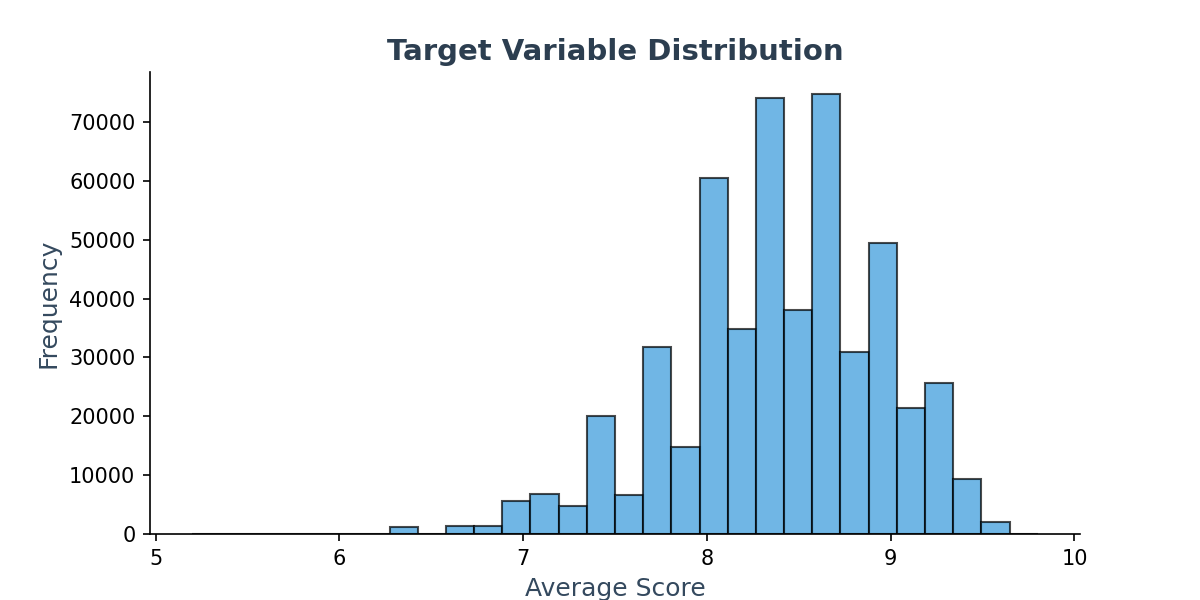

In [18]:
target_rdd = cleaned.select("Average_Score").rdd\
        .flatMap(lambda x: x)\
        .filter(lambda x: x is not None)

# Computing histogram with 30 bins
bins, counts = target_rdd.histogram(30)
bin_widths = [bins[i+1] - bins[i] for i in range(len(bins)-1)]

# Plot
plt.figure(figsize=(8, 4))
plt.bar(bins[:-1], counts, width=bin_widths, color='#3498db', edgecolor='black', alpha=0.7, align='edge')

plt.title('Target Variable Distribution', fontsize=14, fontweight='bold', color='#2c3e50')
plt.xlabel('Average Score', fontsize=12, color='#34495e')
plt.ylabel('Frequency', fontsize=12, color='#34495e')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [19]:
cleaned.select(skewness("Average_Score")).show()

+-----------------------+
|skewness(Average_Score)|
+-----------------------+
|      -0.54592066217199|
+-----------------------+



From the statistical summary we saw that the mean of the 'Average_Score' is close to 8.4
and from the plot we can see that our target variable is slightly skewed to the left.

This could potentially be due to the presence of an outlier around the value 6.3 - 6.4.
To be more specific about the skewness we can use .skew().

In [20]:
cleaned.select(skewness("Average_Score")).show()

+-----------------------+
|skewness(Average_Score)|
+-----------------------+
|      -0.54592066217199|
+-----------------------+



#### Scatterplots

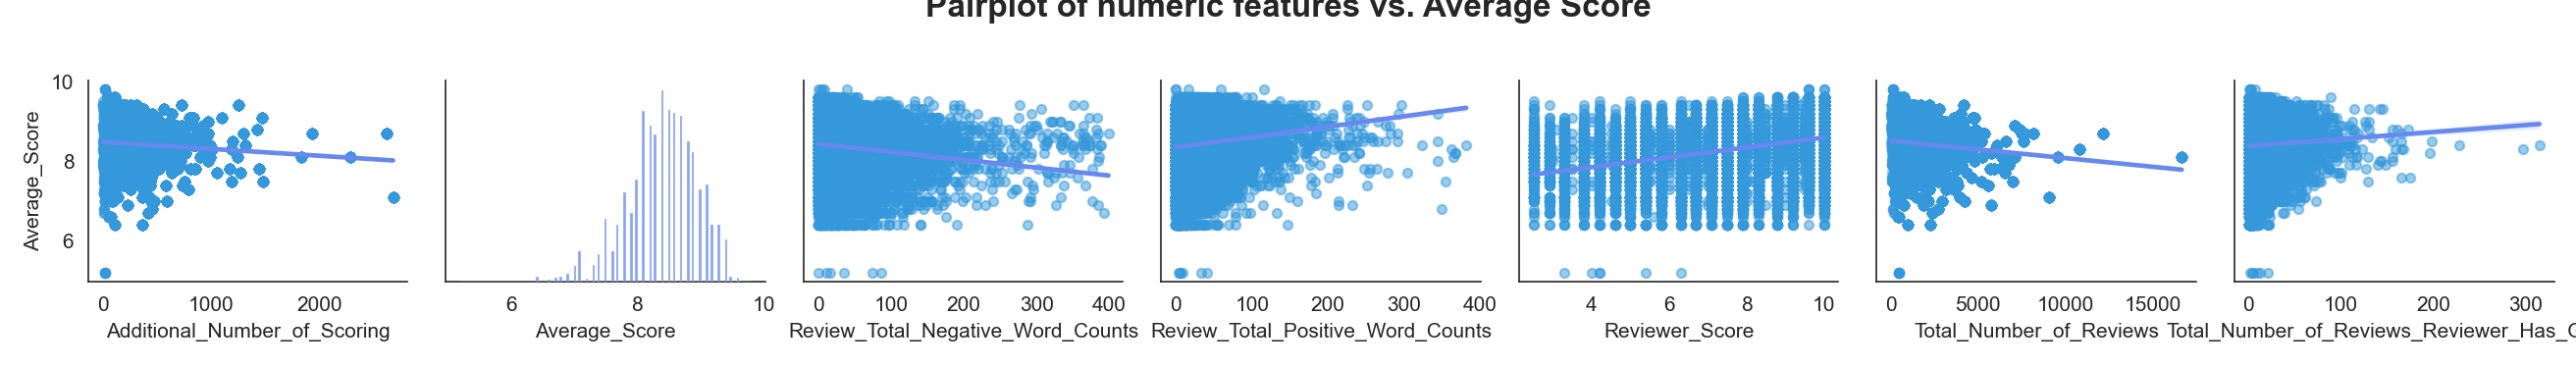

In [21]:
sns.set_style("white")
sns.set_palette("coolwarm")

# Creating the pairplot
g = sns.pairplot(
    sample_pandas,
    x_vars=numerical_features,
    y_vars="Average_Score",
    kind="reg",  # Regression line
    plot_kws={'scatter_kws': {'alpha': 0.5, 's': 20, 'color': '#3498db'}},  # Customize scatter points
    height=2.5,  # Adjust individual plot height
)

# Improve spacing
plt.suptitle("Pairplot of numeric features vs. Average Score", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Show the plot
plt.show()

We plotted some numeric features fitted using linear regression against the target variable `Average_Score`.

We notice, as expected, that individual reviewer review `Reviewer_Score`, and the total
"positive" words used in the review `Review_Total_Positive_Word_Counts` is positively correlated
with `Average_Score`. Perphaps more suprising, the more reviews a user has given `Total_Number_of_Reviews_Reviewer_Has_Given`
is also positively correlated with the venue's average score.

On the other side, we again expected that `Review_Total_Negative_Word_Counts` negatively
correlates to a venue's average score. Perphaps more suprising, the more reviews a venue has
`Total_Number_of_Reviews`, the smaller its average score

#### Visualizing correlation using a heatmap

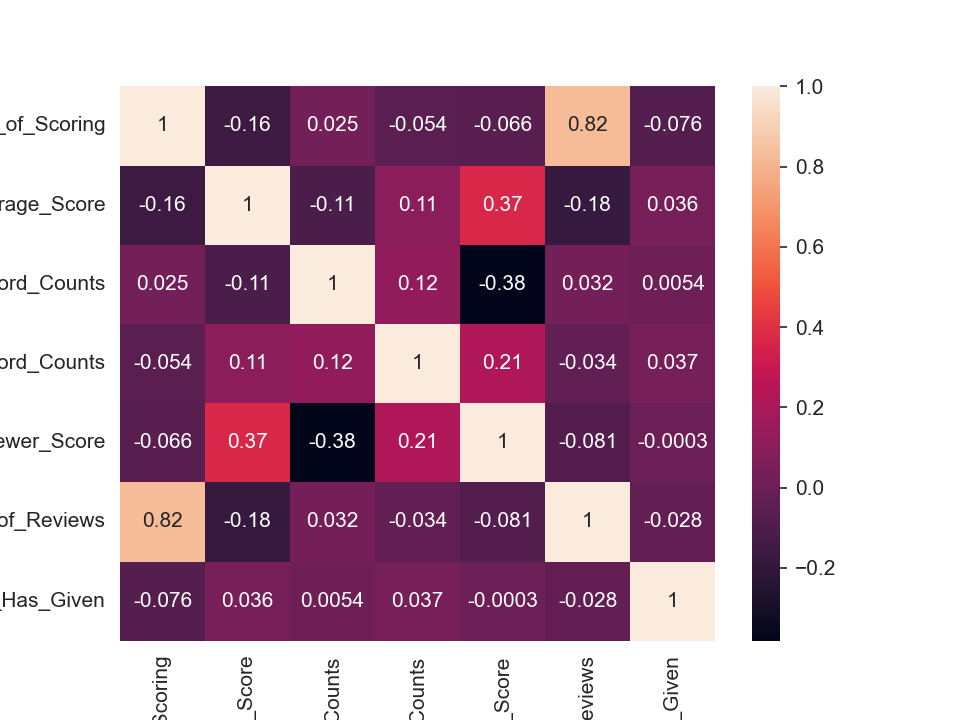

<Axes: >

In [22]:
# An alternative way to visualize linear correlation

fig, ax = plt.subplots()

sns.heatmap(sample_pandas[numerical_features].corr(method='pearson'), annot=True)

From the heatmap we can see that `Additional_Number_of_Scoring` and `Total_Number_of_Reviews`
are highly linearly correlated since the correlation coefficient is equal to 0.82 (very close to 1).

We can also see a weak linear correlation between `Additional_Number_of_Scoring`
and ΄lat΄ where the correlation coefficient is equal to 0.34.

As already studied in the previous pairplots `Average_Score` and `Reviewer_Score`
are linearly correlated even though their correlation is also pretty weak
(correlation coefficient equals to 0.37).

#### Density plots

In [23]:
print(sample_pandas.dtypes)

Additional_Number_of_Scoring                    int32
Average_Score                                 float64
Review_Total_Negative_Word_Counts               int32
Review_Total_Positive_Word_Counts               int32
Reviewer_Score                                float64
Total_Number_of_Reviews                         int32
Total_Number_of_Reviews_Reviewer_Has_Given      int32
dtype: object


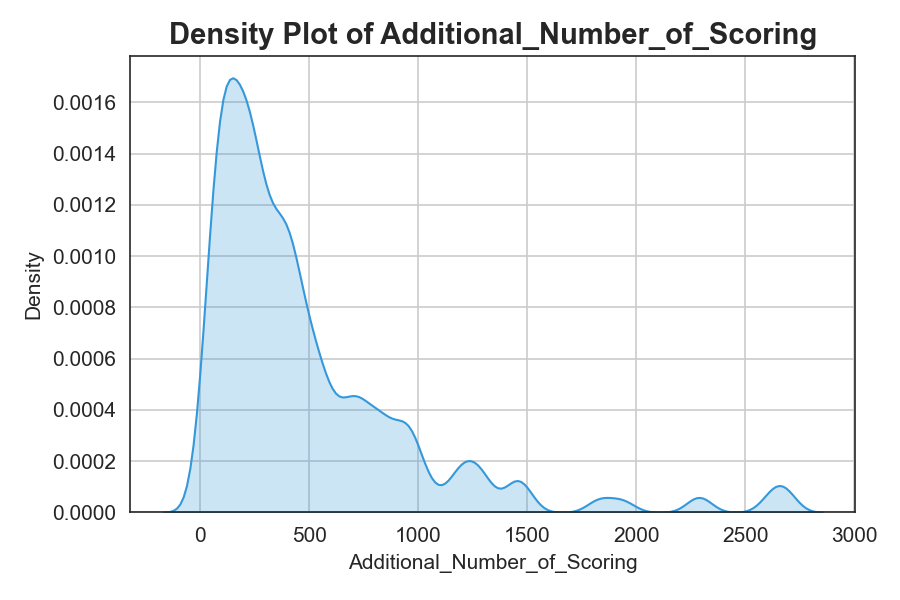

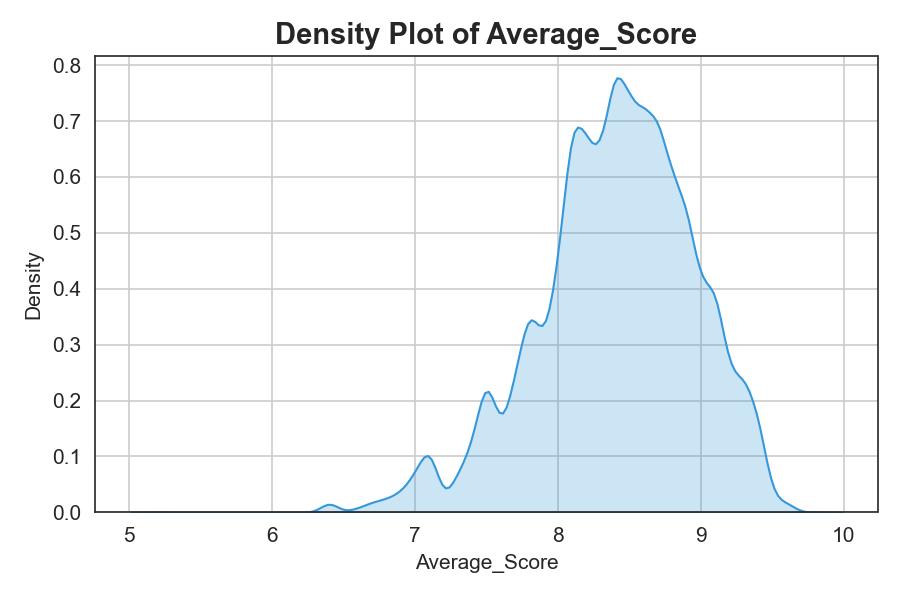

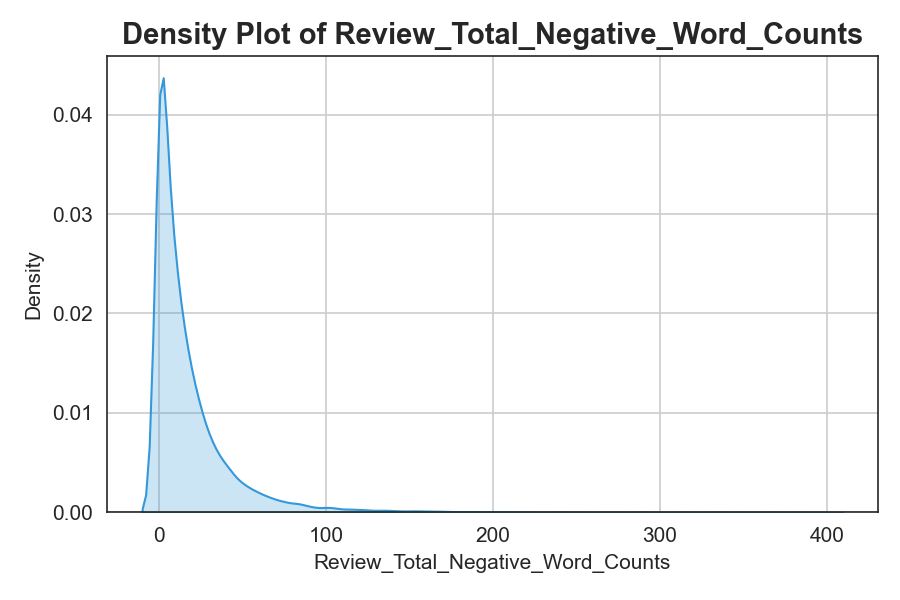

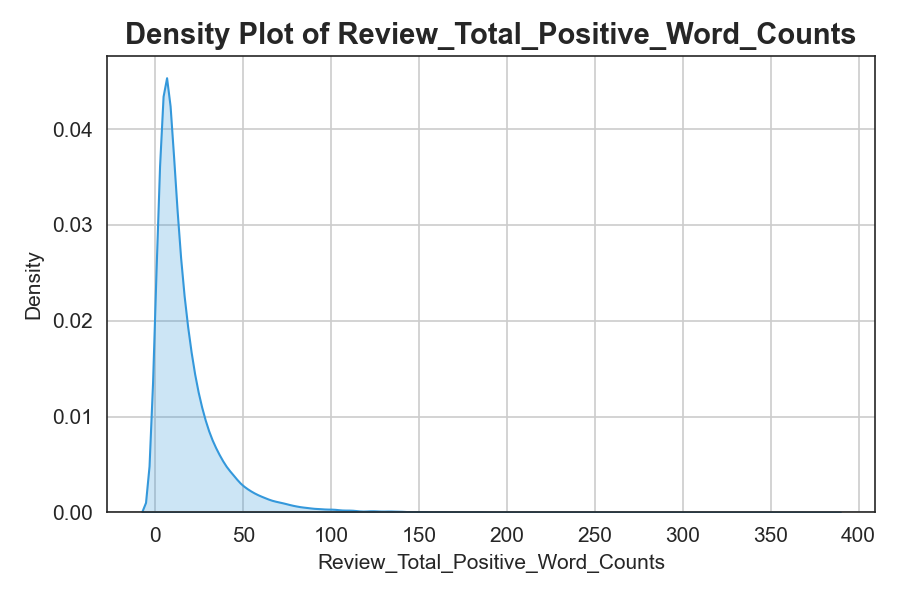

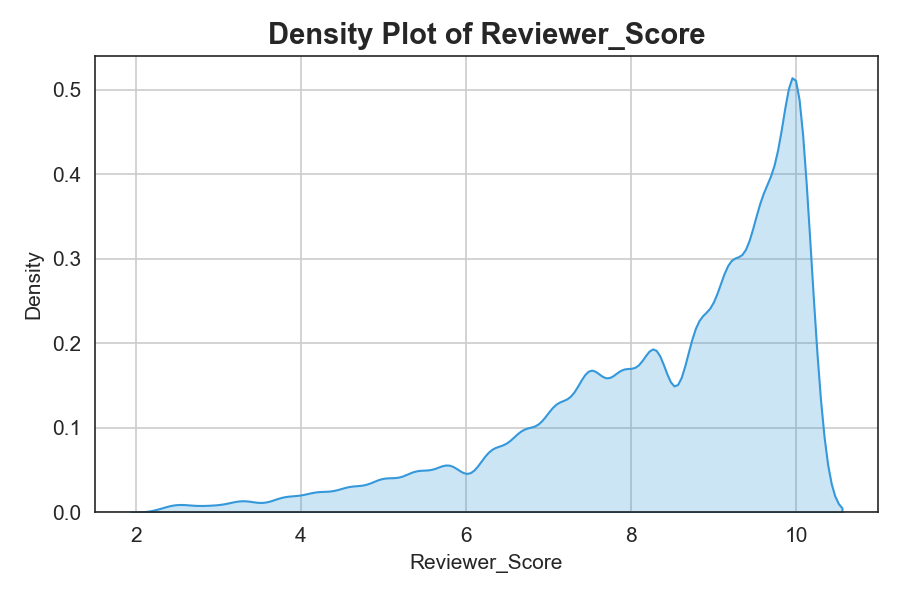

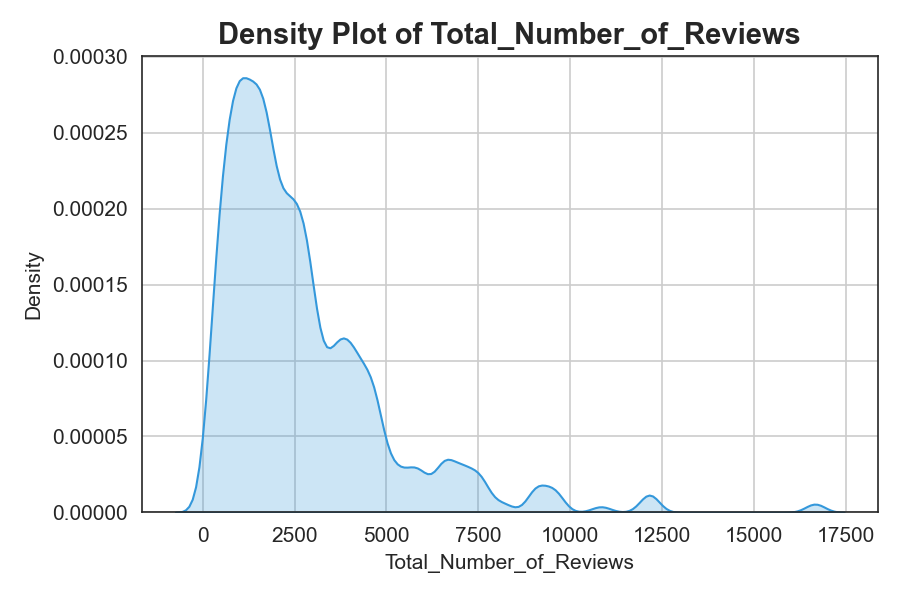

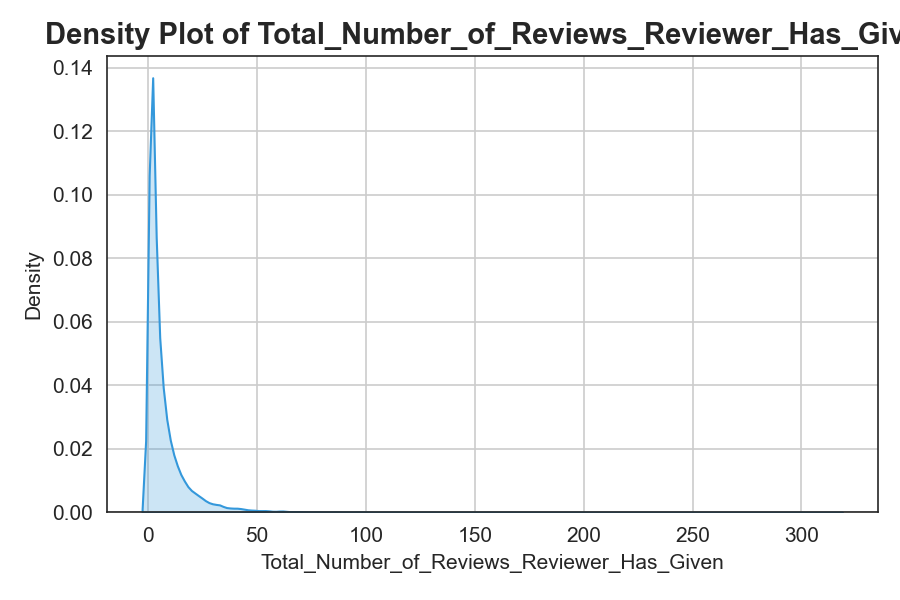

In [24]:
def print_density_plot(feature):
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=sample_pandas, x=col, fill=True, color='#3498db')
    plt.title(f'Density Plot of {feature}', fontsize=14, fontweight='bold')
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for f in numerical_features:
    print_density_plot(f)

From the density plots we can see that `Additional_Number_of_Scoring` is
skewed to the right potentialy due to the presence of extremely high values (outliers).

The same positive skew and outliers are observed in the `Total_Number_of_Reviews`.
The highest consentration of observations is observed around 12500.

`Review_Total_Positive_Word_Counts`, `Review_Total_Negative_Word_Counts` and
`Total_Number_of_Reviews_Reviewer_Has_Given` are also skewed to the right whereas
`Reviewer_Score` is negatively skewed with most od its data points consentrating around 9.8.

#### Boxplots of features with the target variable

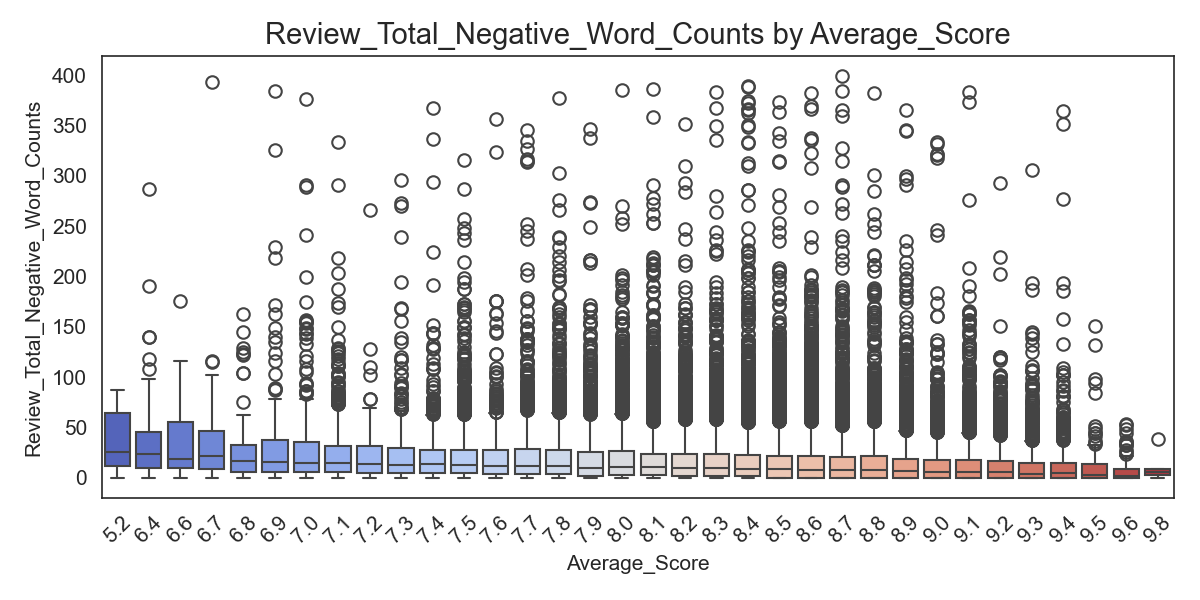

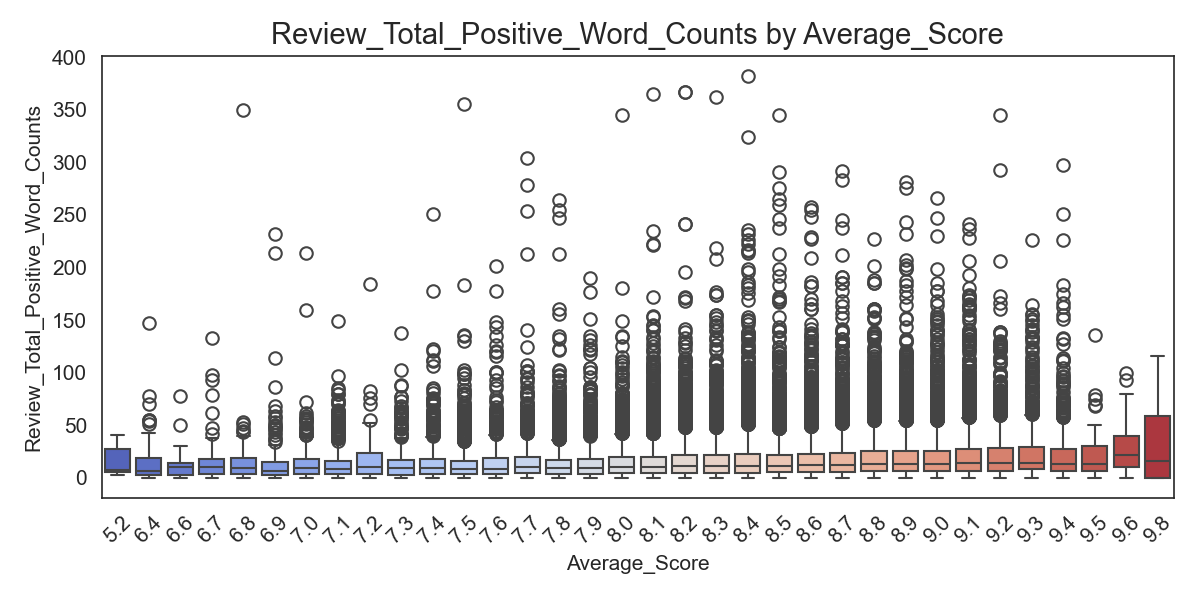

In [25]:
def print_boxplot(feature):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="Average_Score", y=col, data=sample_pandas, palette="coolwarm")
    plt.title(f'{feature} by Average_Score', fontsize=14)
    plt.xlabel("Average_Score")
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


print_boxplot('Review_Total_Negative_Word_Counts')
print_boxplot('Review_Total_Positive_Word_Counts')

`Review_Total_Negative_Word_Counts` by `Average_Score`:
 - There’s a slight downward trend: as `Average_Score` increases, the number of negative words tends to decrease.
 - The median is generally lower for higher scores.
 - The distribution is very wide at each score — especially for mid-range scores (e.g., 7.0 to 8.5), meaning high variability in how many negative words are used regardless of rating.
 - Many outliers, especially in lower scores, suggest some extreme reviews with very high negativity.

`Review_Total_Positive_Word_Counts` by `Average_Score`:
 - Positive trend: as `Average_Score` increases, the number of positive words also increases.
 - The median positive word count rises steadily from low to high scores.
 - Whiskers and outliers increase with higher scores — people who are more satisfied tend to say more and more positive things.

### Natural Language Processing

In [26]:
cleaned.select("Negative_Review", "Positive_Review").show(3, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# We create two new columns: 'Negative_Word_Count' and 'Positive_Word_Count'
# If a review is null, we set the word count to 0
# Otherwise, we trim the review text, split it into words, and count the number of words

cleaned = cleaned.withColumn(
    "Negative_Word_Count",
    when(col("Negative_Review").isNull(), 0)
    .otherwise(size(split(trim(col("Negative_Review")), "\\s+")))
).withColumn(
    "Positive_Word_Count",
    when(col("Positive_Review").isNull(), 0)
    .otherwise(size(split(trim(col("Positive_Review")), "\\s+")))
)

In [27]:
cleaned.select(
    "Negative_Review",
    "Negative_Word_Count",
    "Positive_Review",
    "Positive_Word_Count",
    "Review_Total_Negative_Word_Counts",
    "Review_Total_Positive_Word_Counts"
).show(5, truncate=False)

# We select and display the review texts, the word counts we calculated, and the original total word count columns
# This allows us to visually compare our new word counts with the existing 'Review_Total_Negative_Word_Counts' and 'Review_Total_Positive_Word_Counts'

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

We created two new columns that count the actual number of words in each review.
The existing columns from the original dataset include extra blanks, so their word
counts may be inaccurate.

### Text pre-processing

Before applying any advanced analytics methods to our data, in order to execute text analytics,
we need to pre-process our text. Usually this step is consisted by the methods we shall see below

#### 1.5.1 Tokenization

In [28]:
#Step 1:
cleaned = cleaned.withColumn(
    "Negative_Review_trimmed", when(col("Negative_Review").isNull(), None)
                               .otherwise(trim(col("Negative_Review")))
).withColumn(
    "Positive_Review_trimmed", when(col("Positive_Review").isNull(), None)
                               .otherwise(trim(col("Positive_Review")))
)

# Step 2: Replace nulls with "" for RegexTokenizer
cleaned = cleaned.withColumn(
    "Negative_Review_safe", when(col("Negative_Review_trimmed").isNull(), "").otherwise(col("Negative_Review_trimmed"))
).withColumn(
    "Positive_Review_safe", when(col("Positive_Review_trimmed").isNull(), "").otherwise(col("Positive_Review_trimmed"))
)

# Step 3: Apply RegexTokenizer with pattern \W (non-word characters)
regex_tokenizer_neg = RegexTokenizer(inputCol="Negative_Review_safe", outputCol="Negative_Tokens_Array", pattern="\\W")
regex_tokenizer_pos = RegexTokenizer(inputCol="Positive_Review_safe", outputCol="Positive_Tokens_Array", pattern="\\W")

cleaned = regex_tokenizer_neg.transform(cleaned)
cleaned = regex_tokenizer_pos.transform(cleaned)

# Step 4: Optional – Count tokens
countTokens = udf(lambda tokens: len(tokens) if tokens else None, IntegerType())

cleaned = cleaned.withColumn("Negative_Tokens_Count", when(col("Negative_Review").isNull(), None).otherwise(countTokens(col("Negative_Tokens_Array")))) \
                 .withColumn("Positive_Tokens_Count", when(col("Positive_Review").isNull(), None).otherwise(countTokens(col("Positive_Tokens_Array"))))

# Step 5: Show results
cleaned.select("Negative_Review", "Negative_Tokens_Array", "Negative_Tokens_Count",
               "Positive_Review", "Positive_Tokens_Array", "Positive_Tokens_Count").show(5, truncate=False)

# Prepare reviews: trim, replace nulls, split into words, countwords, and display
# And for the column 'Tags' maybe we should use the regex tokenizer

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+---------------------------------------------------------------

#### 1.5.2 Text Cleanup

In [29]:
def clean_text(c):
  c = lower(c)
  c = regexp_replace(c, ",", " ") # Replace commas with spaces
  c = regexp_replace(c, "[^a-zA-Z0-9\\s]", "") # Keep only alphabetic characters and numbers
  return c

# sentenceDataFrame is the dataframe we defined in our last running cell
# Apply clean_text() to multiple columns
clean_text_df = cleaned.select(
    clean_text(col("Positive_Review")).alias("Positive_Review"),
    clean_text(col("Negative_Review")).alias("Negative_Review"),
    clean_text(col("Hotel_Address")).alias("Hotel_Address"),
    clean_text(col("Hotel_Name")).alias("Hotel_Name"),
    clean_text(col("Tags")).alias("Tags"),
    clean_text(col("Reviewer_Nationality")).alias("Reviewer_Nationality")
)

clean_text_df.printSchema()
clean_text_df.show(20)

root
 |-- Positive_Review: string (nullable = true)
 |-- Negative_Review: string (nullable = true)
 |-- Hotel_Address: string (nullable = true)
 |-- Hotel_Name: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Reviewer_Nationality: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     Positive_Review|     Negative_Review|       Hotel_Address|          Hotel_Name|                Tags|Reviewer_Nationality|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| the room is beau...| the location unf...| s gravesandestra...|         hotel arena| leisure trip    ...|             israel |
| we loved our sta...|                NULL| s gravesandestra...|         hotel arena| leisure trip    ...|          argentina |
| very comfortable...| the hotel only s...|1 15 templeton pl...|    k k hotel george|

We observe that some reviews contain "no" and "negative" as tokens, but they are
actually real negative reviews. For example:
> "The only negative with the room was there was no mirror outside of the bathroom."

On the other hand, some reviews that contain "no negative" actually mean that there
are no negative comments. For example:
> "I have no negative comments."

Based on this observation, we are going to clean the dataset by setting to null
to the negative reviews where "no" and "negative" appear consecutively as tokens.

In [30]:
# Define a UDF to check if the sequence "not at all" appears in the tokens
@udf(BooleanType())
def has_not_at_all_udf(tokens):
    if tokens is None or len(tokens) < 3:
        return False
    return any(tokens[i] == "not" and tokens[i+1] == "at" and tokens[i+2] == "all" for i in range(len(tokens) - 2))

# Now use it to filter
cleaned.filter(has_not_at_all_udf(col("Negative_Tokens_Array"))) \
       .select("Hotel_Name", "Negative_Review", "Negative_Tokens_Array") \
       .show(20, truncate=False)

+------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [31]:
# Count reviews where tokens start with ["not", "at", "all"] and length is 3 or 4
count_not_at_all = cleaned.filter(
    (size(col("Negative_Tokens_Array")).isin(3, 4)) &  # Exactly 3 or 4 5 tokens
    (col("Negative_Tokens_Array")[0] == "not") &
    (col("Negative_Tokens_Array")[1] == "at") &
    (col("Negative_Tokens_Array")[2] == "all")
).count()

print(f"Number of reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: {count_not_at_all}")

Number of reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: 12


In [ ]:
# Replace reviews that start with "not at all" and have exactly 3 or 4 tokens
cleaned = cleaned.withColumn(
    "Negative_Review",
    when(
        (size(col("Negative_Tokens_Array")).isin(3, 4)) &
        (col("Negative_Tokens_Array")[0] == "not") &
        (col("Negative_Tokens_Array")[1] == "at") &
        (col("Negative_Tokens_Array")[2] == "all"),
        None  # Set review to null
    ).otherwise(col("Negative_Review"))
).withColumn(
    "Negative_Tokens_Array",
    when(
        (size(col("Negative_Tokens_Array")).isin(3, 4)) &
        (col("Negative_Tokens_Array")[0] == "not") &
        (col("Negative_Tokens_Array")[1] == "at") &
        (col("Negative_Tokens_Array")[2] == "all"),
        array()  # Set tokens to empty array []
    ).otherwise(col("Negative_Tokens_Array"))
).withColumn(
    "Negative_Tokens_Count",
    when(
        (size(col("Negative_Tokens_Array")).isin(3, 4)) &
        (col("Negative_Tokens_Array")[0] == "not") &
        (col("Negative_Tokens_Array")[1] == "at") &
        (col("Negative_Tokens_Array")[2] == "all"),
        lit(0)  # Set token count to 0
    ).otherwise(col("Negative_Tokens_Count"))
)

In [32]:
# Rerunning the code to verify that the reviews mentioned above have now been replaced
count_not_at_all = cleaned.filter(
    (size(col("Negative_Tokens_Array")).isin(3, 4)) &  # Exactly 3 or 4 5 tokens
    (col("Negative_Tokens_Array")[0] == "not") &
    (col("Negative_Tokens_Array")[1] == "at") &
    (col("Negative_Tokens_Array")[2] == "all")
).count()

print(f"Number of reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: {count_not_at_all}")

Number of reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: 0


Here, we essentially want to consider only reviews where the negative review starts with "not at all". However, we restrict the number of tokens to exactly 3 or 4, in order to include only short reviews that consist solely of these tokens.

For example, reviews like "Club staff was not at all friendly at all in fact" should not be counted, because they have more than 4 tokens and "not at all" is not the entire review — and these are actually negative reviews.

In [33]:
# Find and count reviews where:
# - Negative_Tokens_Array contains "nothing"
# - and the number of tokens is exactly 1 or 2
count_nothing_restricted = cleaned.filter(
    array_contains(col("Negative_Tokens_Array"), "nothing") &
    (size(col("Negative_Tokens_Array")).isin(1, 2))
).count()

print(f"Number of reviews containing the token 'nothing' with 1 or 2 tokens: {count_nothing_restricted}")

Number of reviews containing the token 'nothing' with 1 or 2 tokens: 22626


These reviews do not actually contain anything negative and should be considered as null. Their tokens should also be set to an empty array (zero tokens), so that the models we build later do not make decisions based on them.

In [ ]:
# Replace reviews containing only "nothing" (with 1 or 2 tokens) with null reviews and empty token arrays
cleaned = cleaned.withColumn(
    "Negative_Review",
    when(
        array_contains(col("Negative_Tokens_Array"), "nothing") & size(col("Negative_Tokens_Array")).isin(1, 2),
        None  # Set review to null
    ).otherwise(col("Negative_Review"))
).withColumn(
    "Negative_Tokens_Array",
    when(
        array_contains(col("Negative_Tokens_Array"), "nothing") & size(col("Negative_Tokens_Array")).isin(1, 2),
        array()  # Set tokens to empty array
    ).otherwise(col("Negative_Tokens_Array"))
).withColumn(
    "Negative_Tokens_Count",
    when(
        array_contains(col("Negative_Tokens_Array"), "nothing") & size(col("Negative_Tokens_Array")).isin(1, 2),
        lit(0)  # Set token count to 0
    ).otherwise(col("Negative_Tokens_Count"))
)

In [ ]:
# Rerunning the code to verify that the reviews mentioned above have now been replaced

count_nothing_restricted = cleaned.filter(
    array_contains(col("Negative_Tokens_Array"), "nothing") &
    (size(col("Negative_Tokens_Array")).isin(1, 2))
).count()

print(f"Number of reviews containing the token 'nothing' with 1 or 2 tokens: {count_nothing_restricted}")

In [34]:
# Define UDF to check if "no" is followed by "negative"
@udf(BooleanType())
def has_no_negative_pair_udf(tokens):
    if tokens is None or len(tokens) < 2:
        return False
    return any(tokens[i] == "no" and tokens[i+1] == "negative" for i in range(len(tokens) - 1))

# Apply the filter and show rows
cleaned.filter(has_no_negative_pair_udf(col("Negative_Tokens_Array"))) \
    .select("Negative_Review", "Negative_Tokens_Array") \
    .show(20, truncate=False)

+--------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
|Negative_Review                                                                                                     |Negative_Tokens_Array                                                                                                                  |
+--------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
| We have no negative feedback friendly                                                                              |[we, have, no, negative, feedback, friendly]                                                                         

In [35]:
no_negative_count = cleaned.filter(has_no_negative_pair_udf(col("Negative_Tokens_Array"))).count()

print(f"Number of reviews with 'no' followed by 'negative': {no_negative_count}")

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[107], line 1
----> 1 no_negative_count = cleaned.filter(has_no_negative_udf(col("Negative_Tokens_Array"))).count()
      3 print(f"Number of reviews with 'no' followed by 'negative': {no_negative_count}")

NameError: name 'has_no_negative_udf' is not defined


Some hotels have non-negative reviews recorded as negative reviews, as their texts contain the consecutive words "no" and "negative." These reviews were not treated as nulls, leading to incorrect labeling and introducing bias into the dataset.

In [ ]:
# Set Negative_Review to null, Negative_Tokens_Array to empty array, and Negative_Tokens_Count to 0 if "no negative" appears
cleaned = cleaned.withColumn(
    "Negative_Review",
    when(
        has_no_negative_pair_udf(col("Negative_Tokens_Array")),
        None  # Set review to null
    ).otherwise(col("Negative_Review"))
).withColumn(
    "Negative_Tokens_Array",
    when(
        has_no_negative_pair_udf(col("Negative_Tokens_Array")),
        array()  # Set tokens to empty array []
    ).otherwise(col("Negative_Tokens_Array"))
).withColumn(
    "Negative_Tokens_Count",
    when(
        has_no_negative_pair_udf(col("Negative_Tokens_Array")),
        lit(0)  # Set token count to 0
    ).otherwise(col("Negative_Tokens_Count"))
)

In [36]:
# Rerunning the code to check if the records we observed have been replaced

no_negative_count = cleaned.filter(has_no_negative_pair_udf(col("Negative_Tokens_Array"))).count()

print(f"Number of reviews with 'no' followed by 'negative': {no_negative_count}")

Number of reviews with 'no' followed by 'negative': 0


Now we are going to clean the positive reviews ( same process as above)

In [ ]:
# Define a UDF to check if "no" is immediately followed by "positive" in Positive_Tokens_Array
@udf(BooleanType())
def has_no_positive_pair_udf(tokens):
    if tokens is None or len(tokens) < 2:
        return False
    return any(tokens[i] == "no" and tokens[i+1] == "positive" for i in range(len(tokens) - 1))

# Apply the filter
cleaned.filter(
    has_no_positive_pair_udf(col("Positive_Tokens_Array"))
).select("Positive_Review", "Positive_Tokens_Array") \
 .show(20, truncate=False)

# We filter the dataset to find reviews where "no" is immediately followed by "positive" in the Positive_Tokens_Array
# Then we select and display the original positive review text and its tokens for inspection

In [ ]:
# Count positive reviews where tokens start with ["not", "at", "all"] and length is 3 or 4
count_not_at_all_positive = cleaned.filter(
    (size(col("Positive_Tokens_Array")).isin(3, 4)) &  # Exactly 3 or 4 tokens
    (col("Positive_Tokens_Array")[0] == "not") &
    (col("Positive_Tokens_Array")[1] == "at") &
    (col("Positive_Tokens_Array")[2] == "all")
).count()

print(f"Number of positive reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: {count_not_at_all_positive}")

# We count the number of positive reviews that start with "not at all" and have exactly 3 or 4 tokens

In [ ]:
# Find and count positive reviews where:
# - Positive_Tokens_Array contains "nothing"
# - and the number of tokens is exactly 1 or 2
count_nothing_restricted_positive = cleaned.filter(
    array_contains(col("Positive_Tokens_Array"), "nothing") &
    (size(col("Positive_Tokens_Array")).isin(1, 2))
).count()

print(f"Number of positive reviews containing the token 'nothing' with 1 or 2 tokens: {count_nothing_restricted_positive}")

# We count positive reviews that only say "nothing" and have exactly 1 or 2 tokens

The number of positive reviews that do not correspond to actual positive reviews is smaller compared to the negative reviews we saw earlier. Therefore, we will only replace with missing values the observations that have no comment, and handle only those specific cases.(above code)

In [ ]:
# Replace positive reviews where:
# - Positive_Tokens_Array contains "nothing"
# - and the number of tokens is exactly 1 or 2
cleaned = cleaned.withColumn(
    "Positive_Review",
    when(
        array_contains(col("Positive_Tokens_Array"), "nothing") & size(col("Positive_Tokens_Array")).isin(1, 2),
        None  # Set review to null
    ).otherwise(col("Positive_Review"))
).withColumn(
    "Positive_Tokens_Array",
    when(
        array_contains(col("Positive_Tokens_Array"), "nothing") & size(col("Positive_Tokens_Array")).isin(1, 2),
        array()  # Set tokens to empty array []
    ).otherwise(col("Positive_Tokens_Array"))
).withColumn(
    "Positive_Tokens_Count",
    when(
        array_contains(col("Positive_Tokens_Array"), "nothing") & size(col("Positive_Tokens_Array")).isin(1, 2),
        lit(0)  # Set token count to 0
    ).otherwise(col("Positive_Tokens_Count"))
)

# We replace positive reviews containing only "nothing" with null reviews and empty token arrays

In [ ]:
#Rerruning the code
count_nothing_restricted_positive = cleaned.filter(
    array_contains(col("Positive_Tokens_Array"), "nothing") &
    (size(col("Positive_Tokens_Array")).isin(1, 2))
).count()

print(f"Number of positive reviews containing the token 'nothing' with 1 or 2 tokens: {count_nothing_restricted_positive}")

# We count positive reviews that only say "nothing" and have exactly 1 or 2 tokens

It is important to note that the previous step of cleaning some reviews,
which were considered neither negative nor positive and contained the word "no,"
must take place at this part of the code.

This is because, after removing the stop words, "no" would have been removed.

### Removing Stopwords

Stopwords are words such as "and" and "the" that typically do not add value to the
semantic meaning of a sentence. We typically want to remove these as a means to
reduce the noise in our text datasets.

In [ ]:
# Step 4: Remove Stopwords
stopwords_remover_neg = StopWordsRemover(inputCol="Negative_Tokens_Array", outputCol="Negative_Filtered_Tokens")
stopwords_remover_pos = StopWordsRemover(inputCol="Positive_Tokens_Array", outputCol="Positive_Filtered_Tokens")

cleaned = stopwords_remover_neg.transform(cleaned)
cleaned = stopwords_remover_pos.transform(cleaned)

# Step 5: Count tokens (after stopword removal)
countTokens = udf(lambda tokens: len(tokens) if tokens else None, IntegerType())

cleaned = cleaned.withColumn(
    "Negative_Tokens_Count", when(col("Negative_Review").isNull(), None).otherwise(countTokens(col("Negative_Filtered_Tokens")))
).withColumn(
    "Positive_Tokens_Count", when(col("Positive_Review").isNull(), None).otherwise(countTokens(col("Positive_Filtered_Tokens")))
)

# Step 6: Show results
cleaned.select(
    "Negative_Review", "Negative_Filtered_Tokens", "Negative_Tokens_Count",
    "Positive_Review", "Positive_Filtered_Tokens", "Positive_Tokens_Count"
).show(5, truncate=False)

### 1.7 Lemmatizing

In [ ]:
#Install NLTK and download required resources
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
#Import and define the lemmatizer + UDF:

lemmatizer = WordNetLemmatizer()

# Python function for lemmatizing
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens] if tokens else []

# PySpark UDF
lemmer_udf = udf(lemmatize_tokens, ArrayType(StringType()))

In [ ]:
#Apply lemmatization to the filtered token columns:

cleaned = cleaned.withColumn("Negative_Lemmatized", lemmer_udf(col("Negative_Filtered_Tokens")))
cleaned = cleaned.withColumn("Positive_Lemmatized", lemmer_udf(col("Positive_Filtered_Tokens")))

In [ ]:
#Re-count after lemmatization:
cleaned = cleaned.withColumn("Negative_Lemma_Count", countTokens(col("Negative_Lemmatized")))
cleaned = cleaned.withColumn("Positive_Lemma_Count", countTokens(col("Positive_Lemmatized")))

In [ ]:
#final columns
cleaned.select(
    "Negative_Review", "Negative_Filtered_Tokens", "Negative_Lemmatized", "Negative_Lemma_Count",
    "Positive_Review", "Positive_Filtered_Tokens", "Positive_Lemmatized", "Positive_Lemma_Count"
).show(5, truncate=False)

In [ ]:
# Count how many rows have nulls in Positive_Tokens_Count
positive_nulls = cleaned.filter(col("Positive_Tokens_Count").isNull()).count()

# Count how many rows have nulls in Negative_Tokens_Count
negative_nulls = cleaned.filter(col("Negative_Tokens_Count").isNull()).count()

print(f"Number of nulls in Positive_Tokens_Count: {positive_nulls}")
print(f"Number of nulls in Negative_Tokens_Count: {negative_nulls}")

In [ ]:
# Count nulls in Negative_Tokens_Count
nulls_negative_tokens = cleaned.filter(col("Negative_Lemma_Count").isNull()).count()

# Count nulls in Positive_Tokens_Count
nulls_positive_tokens = cleaned.filter(col("Positive_Lemma_Count").isNull()).count()

print(f"Number of nulls in Negative_Tokens_Count: {nulls_negative_tokens}")
print(f"Number of nulls in Positive_Tokens_Count: {nulls_positive_tokens}")

#### Graph Analytic

In [ ]:
df = cleaned.withColumn(
    "reviewer_id",
    concat_ws("_",
        col("Reviewer_Nationality"),
        col("Tags"),
        col("Total_Number_of_Reviews_Reviewer_Has_Given").cast("string")
    )
)

# Build edge list: reviewer → hotel
edge_list = df.select(
    df["reviewer_id"].alias("src"),
    df["Hotel_Name"].alias("dst"),
    df["Reviewer_Score"].alias("weight")
)

# Graph visualization

def plot_directed_graph(edge_list, weighted=True):
    plt.figure(figsize=(12, 9))
    gPlot = nx.DiGraph()
    edge_labels = {}

    edge_char = "weight" if weighted else "relationship"

    # Add edges (limit for visualization)
    for row in edge_list.select("src", "dst", edge_char).take(1000):
        gPlot.add_edge(row["src"], row["dst"])
        edge_labels[(row["src"], row["dst"])] = row[edge_char]

    # Layout and drawing
    pos = nx.spring_layout(gPlot, k=0.15, iterations=20)
    nx.draw(gPlot, pos, with_labels=False, node_size=50, edge_color='gray')
    nx.draw_networkx_edge_labels(gPlot, pos, edge_labels=edge_labels, font_color="green", font_size=8)

    plt.title("Reviewer–Hotel Bipartite Graph (Profile-Based Reviewer ID)")
    plt.show()

In [ ]:
plot_directed_graph(edge_list, weighted=True)

Bipartite Graph: Reviewers ↔ Hotels
Nodes:
- One set = Reviewers (can be uniquely identified by reviewer + nationality, or anonymized ID)
- Other set = Hotels
- Edges: A review (with edge attributes like score, date, sentiment, tags, etc.)\

Use cases:
- Collaborative filtering for recommendations (like "reviewers similar to you liked...")
- Identify highly connected hotels (most reviewed or diverse set of reviewers)
- Detect reviewer communities or suspicious review patterns (e.g., cliques)

In [ ]:
gPlot = nx.DiGraph()

for row in edge_list.select("src", "dst", "weight").collect():
    gPlot.add_edge(row["src"], row["dst"], weight=row["weight"])

The following code basically ranks a list of popular hotels by how many people reviewed them.

In [ ]:
hotel_degrees = [(n, gPlot.degree(n)) for n in gPlot.nodes if "Hotel" in n]
top_hotels = sorted(hotel_degrees, key=lambda x: x[1], reverse=True)[:10]
print("Top-reviewed hotels:", top_hotels)

In [ ]:
# This need too much time to run so maybe we can just remove it

#from networkx.algorithms import community
#communities = community.greedy_modularity_communities(gPlot.to_undirected())
#print("Found", len(communities), "communities")

In [ ]:
top_reviewers = sorted(
    [(n, gPlot.degree(n)) for n in gPlot.nodes if "Hotel" not in n],
    key=lambda x: x[1], reverse=True
)[:10]
print("Most active reviewer profiles:", top_reviewers)

#### Recommendation systems - Collaborative filtering

In [ ]:
# Step 1: Create a numeric version of reviewer_id and Hotel_Name
reviewer_indexer = StringIndexer(inputCol="reviewer_id", outputCol="reviewer_id_index")
hotel_indexer = StringIndexer(inputCol="Hotel_Name", outputCol="hotel_id_index")

# Fit and transform both
df = reviewer_indexer.fit(df).transform(df)
df = hotel_indexer.fit(df).transform(df)

# Step 2: Split the dataset
(training_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)

# Step 3: Build and train ALS model
als = ALS(
    maxIter=10,
    regParam=0.01,
    userCol="reviewer_id_index",
    itemCol="hotel_id_index",
    ratingCol="Reviewer_Score",
    coldStartStrategy="drop"
)

model = als.fit(training_data)

# Step 4: Generate top 10 hotel recommendations for each reviewer
user_recs = model.recommendForAllUsers(10)

# Step 5: Flatten nested recommendations into rows
user_recs = user_recs.selectExpr("reviewer_id_index", "explode(recommendations) as recommendation")
user_recs = user_recs.selectExpr(
    "reviewer_id_index",
    "recommendation.hotel_id_index as hotel_id_index",
    "recommendation.rating as rating"
)

user_recs.show(truncate=False)

#### RMSE Evaluation

In [ ]:
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Reviewer_Score", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))